In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats as stats
import pandas as pd
import xarray as xr
from fig_params import fig_params;fig_params()


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Pl

In [2]:
def calc_lag1_autocorrelation(array):
    rho = np.correlate(array,array,'same')/(np.var(array)*np.size(array));
    rho = rho[int(np.size(array)/2):]
    # let the time-lag1 = alpha (autocorrelation magnitude)
    alpha = rho[1]
    return(rho,alpha)

In [3]:
# 36 yrs of EKE the zonally-averaged Southern Hemisphere, mid-latitude eddy activity 
# The EKE time series is composed of anomalies, with the seasonal cycle already removed.
with open('/Users/tyler/Desktop/SP22/ATS_655/HW4/era_interim_SH_eke_300hPa.csv') as f:
    EKE = f.readlines()
len(EKE)
EKE = pd.read_csv('/Users/tyler/Desktop/SP22/ATS_655/HW4/era_interim_SH_eke_300hPa.csv',header=None)
EKE = np.squeeze(np.array(EKE))

**1a.** First, you will compute the power spectrum. To do this, apply a Hanning window to your data2 , and split the data into chunks (typically, 256 or 512 days is used). Use an overlapping window technique (WOSA) allowing the windows to overlap by half each time (the standard approach). Plot the resulting
normalized (fraction of variance) power spectrum as a function of frequency.

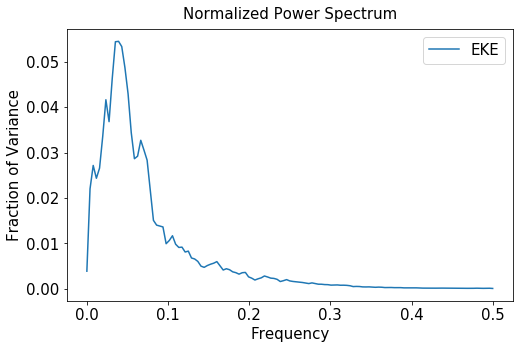

In [4]:
chunkLength = 256
# freq = np.arange()
f, p = sig.welch(EKE,window='hanning',nperseg=chunkLength,noverlap=chunkLength/2,)

# plot power spectrum
fig = plt.figure(figsize=(8,5))
plt.plot(f,p/np.sum(p),label='EKE')
plt.title('Normalized Power Spectrum')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Fraction of Variance');
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW4/figs/P1a.png',dpi=400,bbox_inches='tight')

**1b.** Assess the significance of the spectral peaks using a red-noise null-hypothesis. Plot the rednoise null
hypothesis with the power spectrum of the data.

0.8445834010010216 0.7165313105737893


'\nrho(1) = a  ----- lag-1 memory vector\nTe = 1/e | a_Te = np.exp(-1/Te) -------- e-folding time memory vector\nalpha_Te = how long it takes for rho to reach the e-folding time\n'

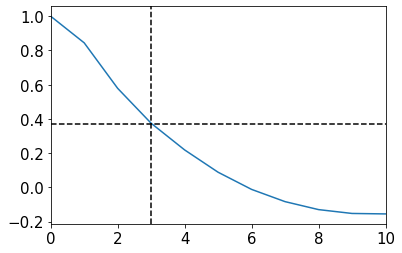

In [5]:
# calculate rho and alpha_lag-1 autocorrelation (alpha)
rho, alpha_lag1 = calc_lag1_autocorrelation(EKE)

# find alpha based on e-folding time = 1/e = 0.368
Te = 1/np.exp(1)


# plot autocorrelation to see Te
plt.plot(np.arange(0,len(rho),1),rho)
plt.xlim(0,10)
plt.axhline(0.368,linestyle='--',color='k')
plt.axvline(3,linestyle='--',color='k')


# calculate alpha_Te
# Te - how long it takes for rho to decrease to 1/e (0.368) of its original value
# a_Te = np.exp(-dt/Te)
alpha_Te = np.exp(-1/3)
print(alpha_lag1,alpha_Te)
'''
rho(1) = a  ----- lag-1 memory vector
Te = 1/e | a_Te = np.exp(-1/Te) -------- e-folding time memory vector
alpha_Te = how long it takes for rho to reach the e-folding time
'''

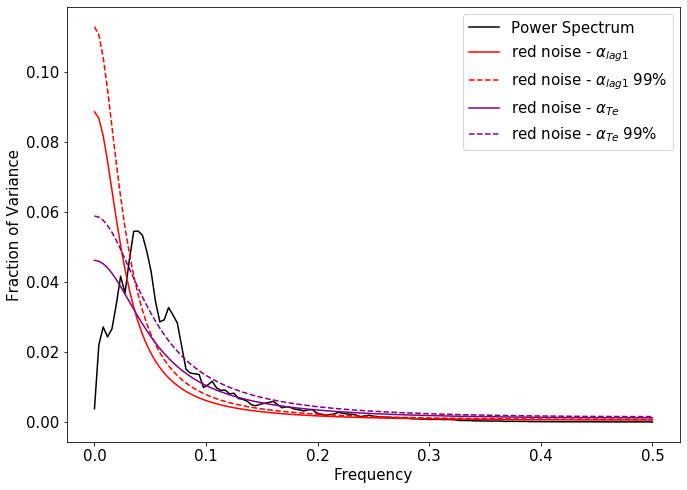

In [6]:
# contstruct rednoise spectrum based off of alpha_lag-1
halfChunk=chunkLength/2
alpha = alpha_lag1
rspec1 = []
for i in np.arange(1,chunkLength/2+2,1):
    rspec1.append((1.-alpha*alpha)/(1.-2.*alpha*np.cos(np.pi*(i-1.)/halfChunk)+alpha*alpha))
rspec1 = np.asarray(rspec1)
rspec1 = rspec1/np.sum(rspec1)


### calc red noise spectrum based off of alpha_Te
alpha = alpha_Te
rspec2 = []
for i in np.arange(1,chunkLength/2+2,1):
    rspec2.append((1.-alpha*alpha)/(1.-2.*alpha*np.cos(np.pi*(i-1.)/halfChunk)+alpha*alpha))
rspec2 = np.asarray(rspec2)
rspec2 = rspec2/np.sum(rspec2)

# calculate significance
numChunks=len(EKE)/chunkLength*2 +1
fstat = stats.f.ppf(.99,numChunks*2,1000)
rspec1_99 = fstat*rspec1

numChunks=len(EKE)/chunkLength*2 +1
fstat = stats.f.ppf(.99,numChunks*2,1000)
rspec2_99 = fstat*rspec2
###############

# plot
fig = plt.figure(figsize=(11,8))

plt.plot(f,p/np.sum(p),color='k',label='Power Spectrum')
plt.plot(f,rspec1/np.sum(rspec1),color='red',label=r'red noise - $\alpha_{lag1}$')
plt.plot(f,rspec1_99,color='red',linestyle='--',label=r'red noise - $\alpha_{lag1}\;99\% $')

plt.plot(f,rspec2/np.sum(rspec2),color='purple',label=r'red noise - $\alpha_{Te}$')
plt.plot(f,rspec2_99,color='purple',linestyle='--',label=r'red noise - $\alpha_{Te}\;99\% $')

plt.legend(prop={'size':15});plt.xlabel('Frequency');plt.ylabel('Fraction of Variance');
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW4/figs/1b.png',dpi=400,bbox_inches='tight')

frequency = cycles/timestep

timestep for EKE = chunkLength = 256

In [7]:
# find peak frequency,
max_ind = np.where(p/np.sum(p) == np.max(p/np.sum(p)))
print('Fraction of Variance:',(p/np.sum(p))[max_ind])
print('Frequency at peak power:',f[max_ind])
cycles = float(f[max_ind])*chunkLength;print(cycles,'cycles')

Fraction of Variance: [0.05453608]
Frequency at peak power: [0.0390625]
10.0 cycles


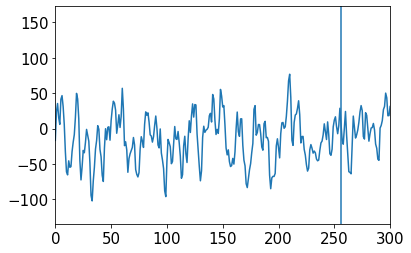

In [8]:
plt.plot(EKE)
plt.xlim(0,300)
plt.axvline(256)

**1c.** Comment on how your red-noise test differs if you define the memory of the red-noise fit based on the
lag-1 autocorrelation versus the e-folding time of the autocorrelation. For the degrees of freedom you
can neglect any smoothing from the window.
- The alpha for lag-1 autocorrelation = 0.84 while the alpha for e-folding time (which i found was approximately 3. days) was 0.72. This means less memory when using the e-folding time to calculate alpha and more memory for the lag-1 autocorrelation definition. However, we see red noise spectrum with lag-1 drop off faster than the red noise spectrum with e-folding time scale alpha.

**1d.** Write a report summarizing your findings and the physical meaning behind the peaks (or lack of peaks)
you found.

First I took a chunk size of 256 leading to 51 realizations (or equally spaced chunks). Each chunk has two degrees of freedom (DOF) leading to 102 DOF. However we are overlapping the chunks by half of the chunkLength so the DOF is actually DOF = # data points / (chunkLength/2). Even then there is a smoothing done by the Hanning window (to cancel the sidelobes negative weighting, we increase the width of the main lobe). This effectively smooths the frequencies because we are taking a weighting a wider width of the original time series for each chunk. This also has an effect on the DOF, which is incorporated by multiplying by a weighting factor f_w = 1.2 (for a Hanning window). Thus I calculated the total DOF = 123.


The fraction of variance of for EKE seems to peak at the very low frequencies then decrease towards the large frequencies, this means most of the power 

### P2

In [11]:
ds = xr.open_mfdataset('/Users/tyler/Desktop/SP22/ATS_655/HW4/ERA5*')
aej_wind = ds.mean(axis=(1,2,3))
wspd = np.sqrt(aej_wind.u.values**2 + aej_wind.v.values**2)
wspd = wspd - np.mean(wspd)

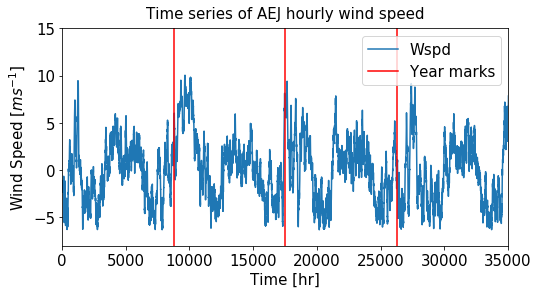

In [12]:
fig = plt.figure(figsize=(8,4))
plt.plot(wspd,label='Wspd')
plt.axvline(8760, color = "red")
plt.axvline(8760*2, color = "red")
plt.axvline(8760*3, color = "red",label='Year marks')
plt.xlim(0,8760*4)
plt.ylim(-8,15)
plt.title('Time series of AEJ hourly wind speed')
plt.ylabel(r'Wind Speed [$ms^{-1}$]');
plt.xlabel('Time [hr]');
plt.legend(loc='upper right')
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW4/figs/2_timeseries.png',dpi=400,bbox_inches='tight')

Text(0.5, 1.0, 'Autocorrelation of AEJ wind')

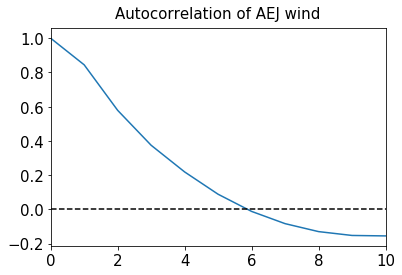

In [15]:
# plot autocorrelation of AEJ windspeed
plt.plot(np.arange(0,len(rho),1),rho)
plt.xlim(0,10)
plt.axhline(0,linestyle='--',color='k')
plt.title('Autocorrelation of AEJ wind')

Text(0.5, 1.0, 'Power Spectrum of AEJ hourly wind speed ')

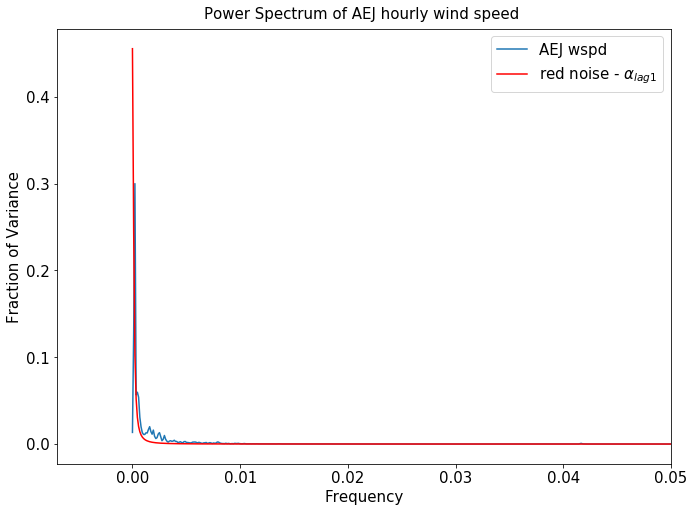

In [19]:
#2a.
chunkLength = 8760
# freq = np.arange()
f, p = sig.welch(wspd,window='hanning',nperseg=chunkLength,noverlap=chunkLength/2,)

# calculate the red-noise spectrum (lag-1 autocorrelation)
rho, alpha_lag1 = calc_lag1_autocorrelation(wspd)
halfChunk=chunkLength/2
alpha = alpha_lag1
rspec1 = []
for i in np.arange(1,chunkLength/2+2,1):
    rspec1.append((1.-alpha*alpha)/(1.-2.*alpha*np.cos(np.pi*(i-1.)/halfChunk)+alpha*alpha))
rspec1 = np.asarray(rspec1)
rspec1 = rspec1/np.sum(rspec1)

# plot power spectrum
fig = plt.figure(figsize=(11,8))
plt.plot(f,p/np.sum(p),label='AEJ wspd')
plt.plot(f,rspec1/np.sum(rspec1),color='red',label=r'red noise - $\alpha_{lag1}$')
# plt.title('')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Fraction of Variance');
plt.xlim(-0.007,0.05);
plt.title('Power Spectrum of AEJ hourly wind speed ')

# plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW4/figs/2_powerspectrum1.png',dpi=400,bbox_inches='tight')

In [27]:
# averaging function to get average windspeeds
wspd_avg = np.zeros(int(len(wspd)/(24*7)))
for i in np.arange(0,len(wspd_avg)):
     wspd_avg[i] = wspd[i*24*7:24*7*i+1]

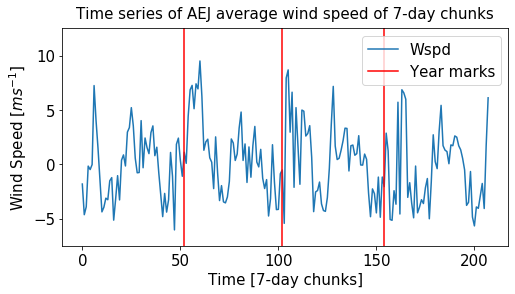

In [28]:
fig = plt.figure(figsize=(8,4))
plt.plot(np.arange(0,len(wspd_avg)),wspd_avg,label='Wspd')
plt.axvline(52,color='red',label='Year marks');plt.axvline(102,color='red');plt.axvline(154,color='red')
plt.title('Time series of AEJ average wind speed of 7-day chunks')
plt.ylabel(r'Wind Speed [$ms^{-1}$]');
plt.xlabel('Time [7-day chunks]');
plt.ylim(-7.5,12.5)
plt.legend()
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW4/figs/2_timeseries_avg.png',dpi=400,bbox_inches='tight')

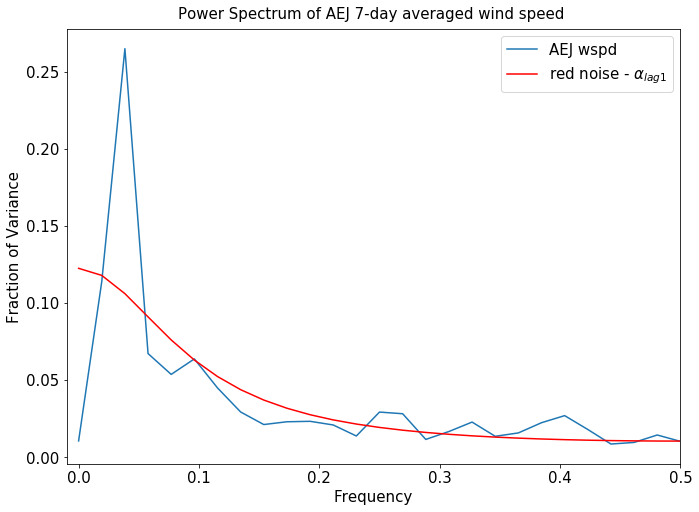

In [29]:
# Redo with 7-day resolution of data
#2a.
chunkLength = 52
f, p = sig.welch(wspd_avg,window='hanning',nperseg=chunkLength,noverlap=chunkLength/2,)

# calculate the red-noise spectrum (lag-1 autocorrelation)
rho, alpha_lag1 = calc_lag1_autocorrelation(wspd_avg)
# alpha_lag1=0.9
halfChunk=chunkLength/2
alpha = alpha_lag1
rspec1 = []
for i in np.arange(1,chunkLength/2+2,1):
    rspec1.append((1.-alpha*alpha)/(1.-2.*alpha*np.cos(np.pi*(i-1.)/halfChunk)+alpha*alpha))
rspec1 = np.asarray(rspec1)
rspec1 = rspec1/np.sum(rspec1)

# plot power spectrum
fig = plt.figure(figsize=(11,8))
plt.plot(f,p/np.sum(p),label='AEJ wspd')
plt.plot(f,rspec1/np.sum(rspec1),color='red',label=r'red noise - $\alpha_{lag1}$')
# plt.title('')
plt.legend(prop={'size':15})
plt.xlabel('Frequency')
plt.ylabel('Fraction of Variance');
plt.xlim(-0.01,0.5);
plt.title('Power Spectrum of AEJ 7-day averaged wind speed ');
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW4/figs/2_powerspectrum2.png',dpi=400,bbox_inches='tight')

In [30]:
# calculate #cycles for peak power
ind = np.where((p/np.sum(p)) == np.max(p/np.sum(p)))
numCycles=f[2]*chunkLength
print(numCycles,'cycles')
# at max fraction of variance is some frequency. convert freq to cycles = 2

2.0 cycles


In [31]:
# freq surpassing red-noise null-hypothesis test
ind = np.array(np.where(p/np.sum(p) > rspec1/np.sum(rspec1)))[0]
vals = [round(val,4) for val in f[ind]]
print(vals)

[0.0385, 0.0962, 0.25, 0.2692, 0.3077, 0.3269, 0.3462, 0.3654, 0.3846, 0.4038, 0.4231, 0.4808]


In [32]:
# degrees of freedom
1.2*208/(52/2)

9.6